In [17]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def print_and_save_metrics(model_name):
    val_preds = pd.read_csv(f'/home/ml4science0/novozymes/predictions/{model_name}.csv')
    pcc_array = []
    scc_array = []
    rmse_array = []
    mae_array = []
    metrics = []
    for i in range(5):
        true_values = val_preds[f'tm_{i}']
        pred_values = val_preds[f'preds_{i}']

        # Calculate performance metrics
        pcc, _ = pearsonr(true_values, pred_values)
        scc, _ = spearmanr(true_values, pred_values)
        rmse = np.sqrt(mean_squared_error(true_values, pred_values))
        mae = mean_absolute_error(true_values, pred_values)
        pcc_array.append(pcc)
        scc_array.append(scc)
        rmse_array.append(rmse)
        mae_array.append(mae)

        metrics.append({
        'PCC': pcc,
        'SCC': scc,
        'RMSE': rmse,
        'MAE': mae
        })

    metrics_df = pd.DataFrame(metrics)
    print(metrics_df)

    metrics = {
        'PCC_AVG': np.array(pcc_array).mean(),
        'SCC_AVG': np.array(scc_array).mean(),
        'RMSE_AVG': np.array(rmse_array).mean(),
        'MAE_AVG': np.array(mae_array).mean(),
        'PCC_STD': np.array(pcc_array).std(),
        'SCC_STD': np.array(scc_array).std(),
        'RMSE_STD': np.array(rmse_array).std(),
        'MAE_STD': np.array(mae_array).std(),
        }
    
    metrics_df = pd.DataFrame([metrics])
    print(metrics_df.to_string(index=False))
    metrics_df.to_csv(f'/home/ml4science0/novozymes/metrics and plots/{model_name}.csv', index=False)

In [29]:
def plot_and_save(model_name):
    val_preds = pd.read_csv(f'/home/ml4science0/novozymes/predictions/{model_name}.csv')

    # Get the predictions from the first fold
    true_values = val_preds['tm_0']
    pred_values = val_preds['preds_0']

    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=true_values, y=pred_values)
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('True vs Predicted values')
    plt.savefig(f'/home/ml4science0/novozymes/metrics and plots/{model_name}.png')

        PCC       SCC       RMSE        MAE
0  0.484515  0.374316  11.977824   8.609857
1  0.472423  0.359774  11.701439   8.513866
2  0.519038  0.384706  11.247551   8.407301
3  0.470874  0.343038  12.225794   8.747874
4  0.485510  0.349547  13.380243  10.274474
 PCC_AVG  SCC_AVG  RMSE_AVG  MAE_AVG  PCC_STD  SCC_STD  RMSE_STD  MAE_STD
0.486472 0.362276  12.10657 8.910674 0.017355 0.015404  0.714853 0.691055


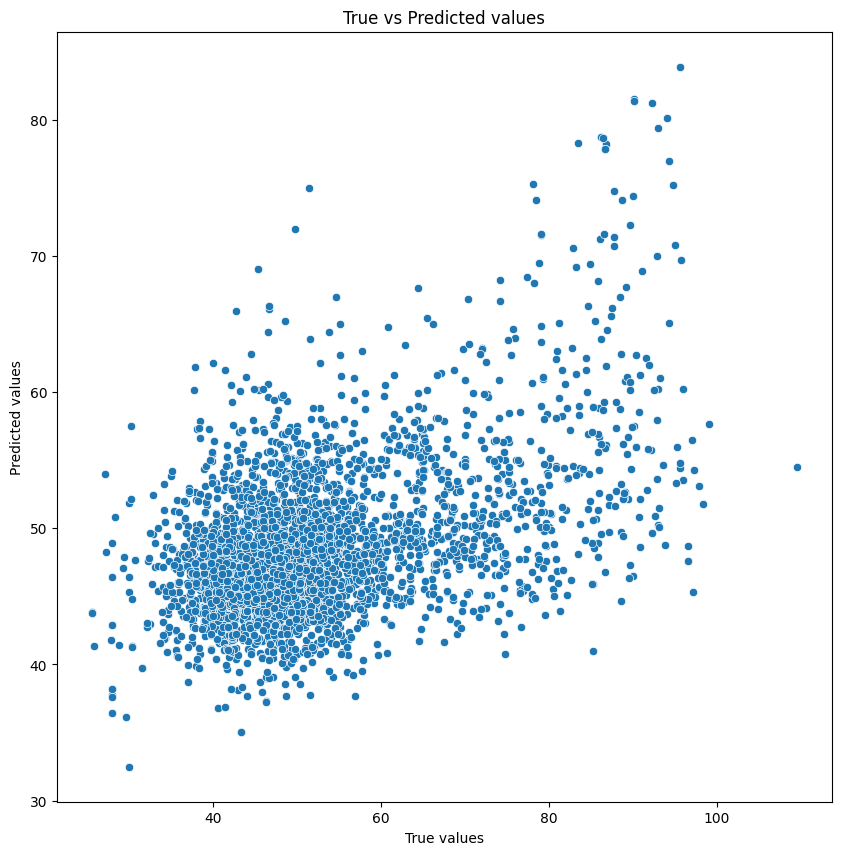

In [22]:
print_and_save_metrics("carbonara_simple_z")
plot_and_save("carbonara_simple_z")

        PCC       SCC       RMSE       MAE
0  0.488023  0.373922  11.221461  8.276341
1  0.490808  0.367878  11.773269  9.053150
2  0.504368  0.386858  11.650824  8.920771
3  0.472114  0.360316  11.608124  8.655493
4  0.477871  0.355241  11.655871  8.551337
 PCC_AVG  SCC_AVG  RMSE_AVG  MAE_AVG  PCC_STD  SCC_STD  RMSE_STD  MAE_STD
0.486637 0.368843  11.58191 8.691419 0.011149 0.011036  0.188387 0.274465


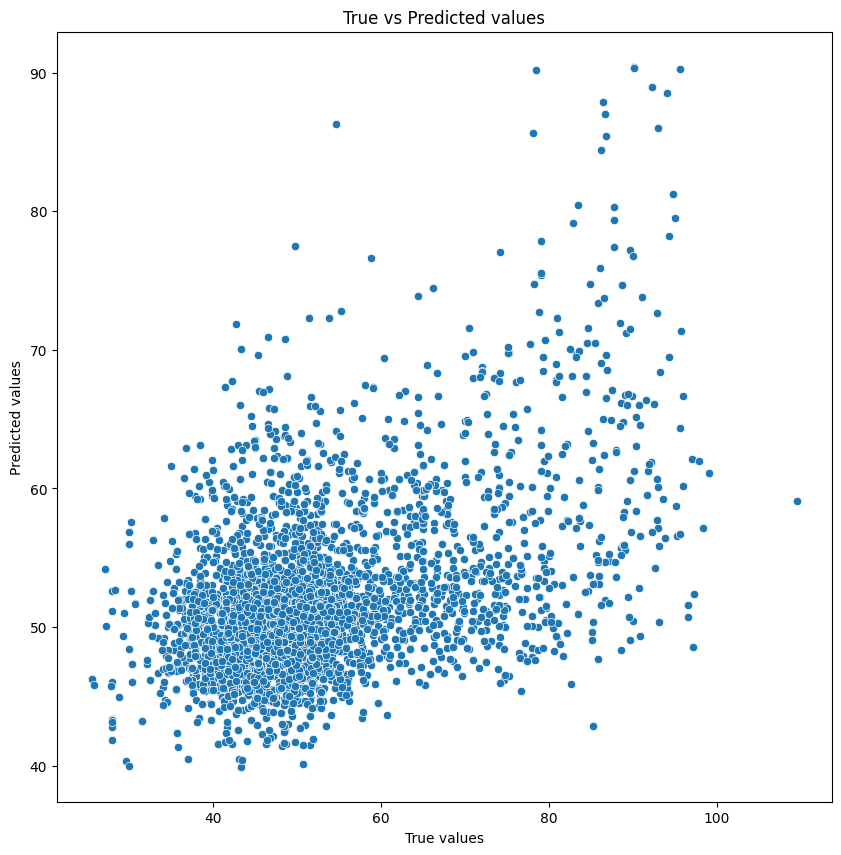

In [23]:
print_and_save_metrics("carbonara_simple_z_plddt")
plot_and_save("carbonara_simple_z_plddt")

        PCC       SCC       RMSE       MAE
0  0.290230  0.235938  12.324640  8.991956
1  0.279738  0.213771  12.587840  9.407176
2  0.259824  0.202315  12.727457  9.501251
3  0.265730  0.198625  12.449461  9.271029
4  0.287047  0.208150  12.432510  8.962257
 PCC_AVG  SCC_AVG  RMSE_AVG  MAE_AVG  PCC_STD  SCC_STD  RMSE_STD  MAE_STD
0.276514  0.21176 12.504382 9.226734 0.011869 0.013141  0.139439 0.216772


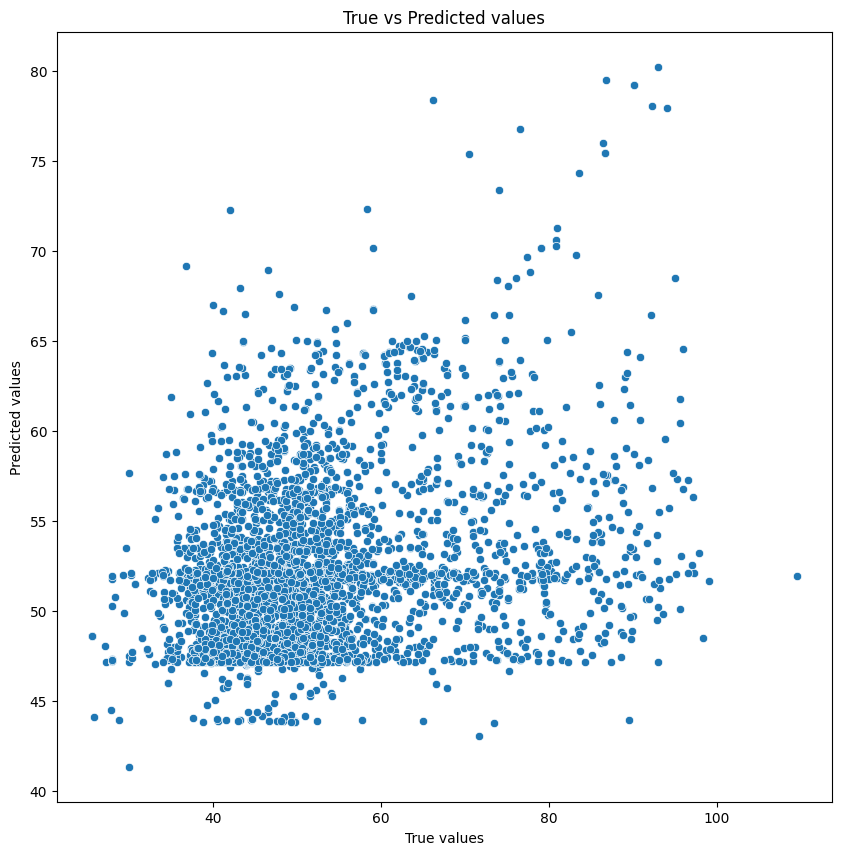

In [25]:
print_and_save_metrics("carbonara_rnn_z_plddt")
plot_and_save("carbonara_rnn_z_plddt")

        PCC       SCC       RMSE       MAE
0  0.296578  0.245624  12.351800  9.253744
1  0.269318  0.221765  12.701538  9.557345
2  0.267235  0.206453  12.693408  9.322288
3  0.265914  0.186588  12.461589  9.141669
4  0.238828  0.164454  12.542366  9.320967
 PCC_AVG  SCC_AVG  RMSE_AVG  MAE_AVG  PCC_STD  SCC_STD  RMSE_STD  MAE_STD
0.267574 0.204977  12.55014 9.319202 0.018295 0.027987  0.134675 0.136035


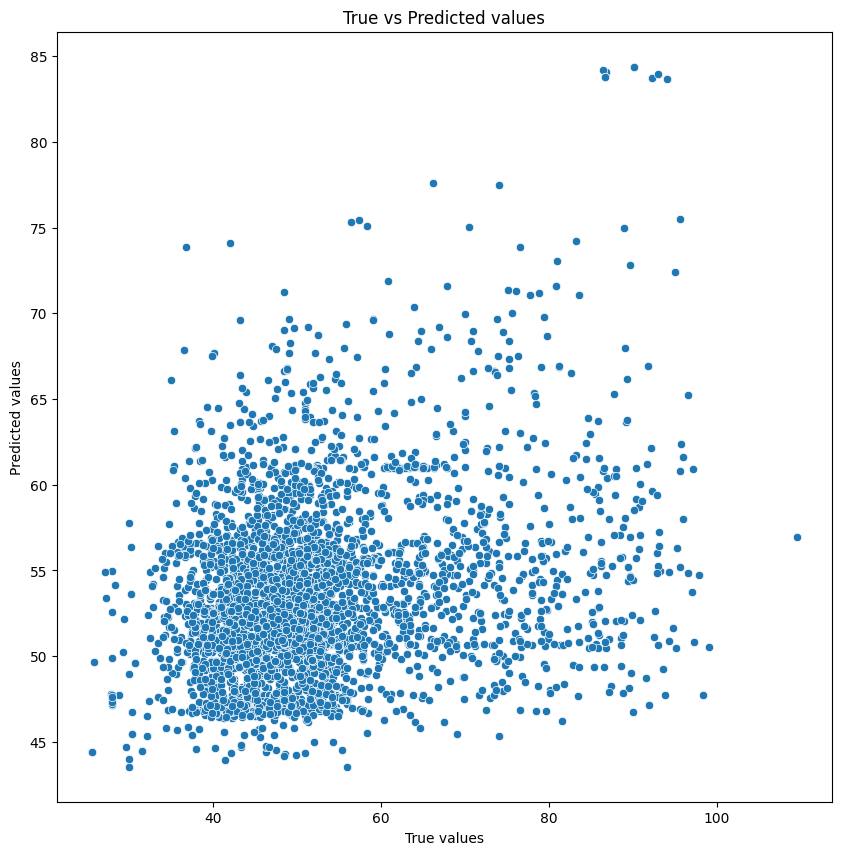

In [31]:
print_and_save_metrics("carbonara_rnn_z")
plot_and_save("carbonara_rnn_z")

        PCC       SCC      RMSE       MAE
0  0.786793  0.556129  7.468684  5.546361
1  0.772522  0.567478  7.556452  5.514359
2  0.774287  0.565723  7.783203  5.792485
3  0.762504  0.554504  7.859919  5.751196
4  0.773747  0.557245  7.729691  5.644845
 PCC_AVG  SCC_AVG  RMSE_AVG  MAE_AVG  PCC_STD  SCC_STD  RMSE_STD  MAE_STD
0.773971 0.560216   7.67959 5.649849 0.007722 0.005314  0.145196 0.109278


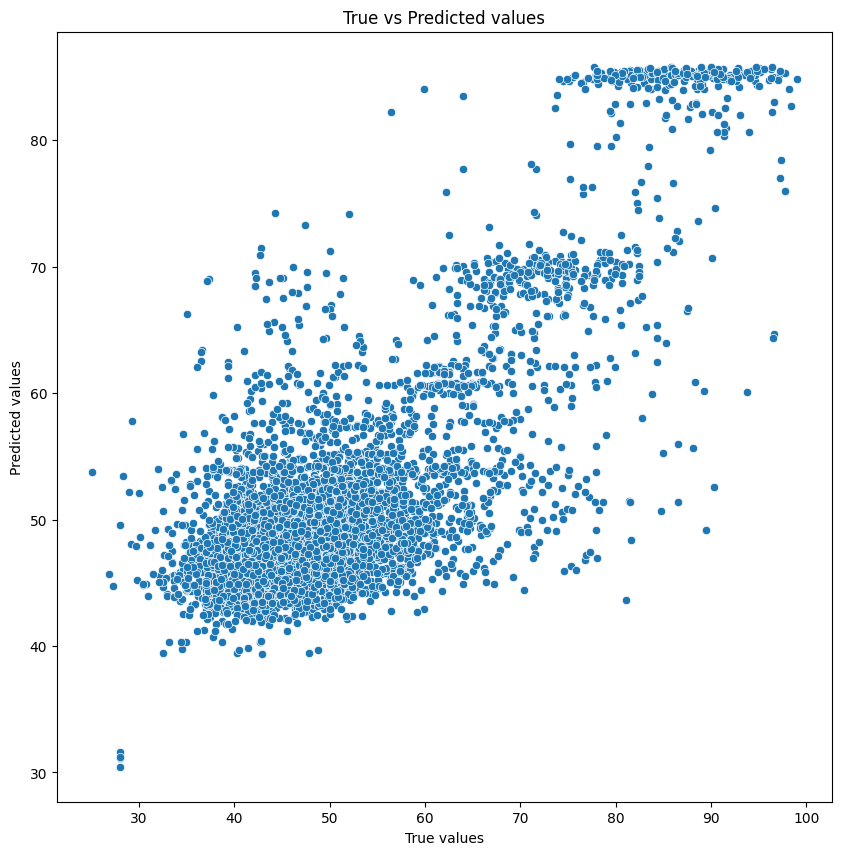

In [30]:
print_and_save_metrics("esm")
plot_and_save("esm")